Epoch 40 Iteration 40
Accuracy:  0.94
Training Loss: 4.1192


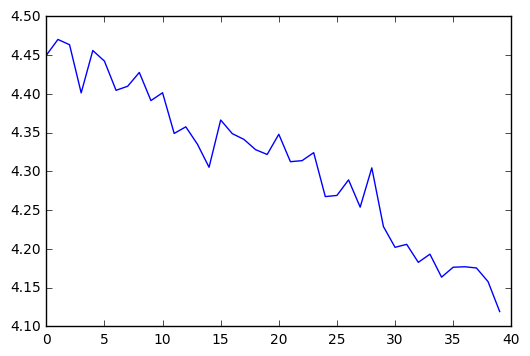

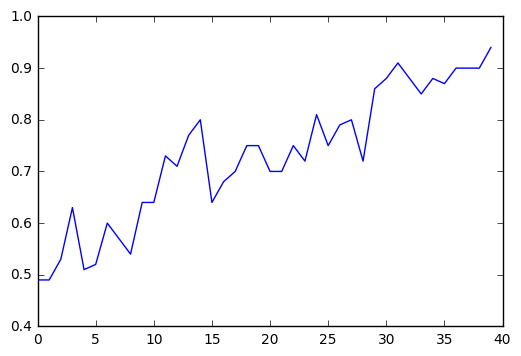

Time Elapsed for Epoch:40 is 6.0619718194 minutes


KeyboardInterrupt: 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf

import vgg16_trainable as vgg16
import os
import time
import numpy as np
import utils
from IPython.display import clear_output

PRETRAINED_MODEL_PATH= None
N_EPOCHS = 100
INIT_LEARNING_RATE = 0.001
WEIGHT_DECAY_RATE = 0.0005
MOMENTUM = 0.9
IMAGE_HEIGHT  = 224    #960
IMAGE_WIDTH   = 224    #720
NUM_CHANNELS  = 3
BATCH_SIZE = 50
N_CLASSES = 2
DROPOUT = 0.50
NUM_GPUS =1
ckpt_dir = "/home/kami/ckpt_dir"
LOGS_PATH = '/home/kami/tensorflow_logs'
WEIGHT_PATH = '.npy'
TRAINSET_PATH = '/home/kami/PycharmProjects/csvgeneration/imagenetdata100-1.csv'
VALSET_PATH ='/home/kami/PycharmProjects/csvgeneration/imagenetdata100-1.csv'


def _tower_loss(images, labels,train_mode, scope):
    # Build inference Graph.
    
    vgg = vgg16.Vgg16()
    vgg.build(images, train_mode)
    weights_only = filter(lambda x: x.name.endswith('W:0'), tf.trainable_variables())
    for x in xrange(len(weights_only)):
        print (weights_only[x].name)
    # print number of variables used: 143667240 variables, i.e. ideal size = 548MB
    print vgg.get_var_count()
    
    # Build the portion of the Graph calculating the losses. Note that we will
    # assemble the total_loss using a custom function below.
    loss_tf = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(vgg.prob, labels), name='loss_tf')
    #loss_summary = tf.summary.scalar("loss", loss_tf)
    weights_only = filter( lambda x: x.name.endswith('W:0'), tf.trainable_variables())
    weight_decay = tf.reduce_sum(tf.add_n([tf.nn.l2_loss(x) for x in weights_only])) * WEIGHT_DECAY_RATE
    total_loss = loss_tf + weight_decay
    
    correct_pred = tf.equal(tf.argmax(vgg.prob, 1), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    return total_loss, accuracy


def average_gradients(tower_grads):
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
    # Note that each grad_and_vars looks like the following:
    #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
        # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)

            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(0,grads)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads


def train():
    """Train CIFAR-10 for a number of steps."""
    with tf.Graph().as_default(), tf.device('/cpu:0'):
        learning_rate = tf.placeholder(tf.float32, [])
        opt = tf.train.MomentumOptimizer(INIT_LEARNING_RATE,MOMENTUM)
        csv_path = tf.train.string_input_producer([TRAINSET_PATH], shuffle=True)
        textReader = tf.TextLineReader()
        _,csv_content = textReader.read(csv_path)
        im_name, im_label = tf.decode_csv(csv_content, record_defaults=[[""], [1]])

        im_content = tf.read_file(im_name)
        train_image = tf.image.decode_jpeg(im_content, channels=3)
        train_image = tf.cast(train_image, tf.float32)/255. # necessary for mapping rgb channels from 0-255 to 0-1 float.
        # train_image = augment(train_image)
        size = tf.cast([IMAGE_HEIGHT, IMAGE_WIDTH], tf.int32)
        train_image = tf.image.resize_images(train_image, size)
        train_label = tf.cast(im_label, tf.int64) # unnecessary
        train_image_batch, train_label_batch = tf.train.shuffle_batch([train_image, train_label], batch_size=BATCH_SIZE,
                                                                      capacity = 1000 + 3*BATCH_SIZE, min_after_dequeue = 1000)

        images_splits = tf.split(0, NUM_GPUS, train_image_batch)
        labels_splits = tf.split(0, NUM_GPUS, train_label_batch)
        train_mode = tf.placeholder(tf.bool)
        
        # Calculate the gradients for each model tower.
        tower_grads = []
        tower_accuracy = []
        for i in xrange(NUM_GPUS):
            with tf.device('/cpu:%d' % i):
                with tf.name_scope('%s_%d' % ('tower', i)) as scope:
                    # Calculate the loss for one tower of the CIFAR model. This function
                    # constructs the entire CIFAR model but shares the variables across
                    # all towers.
                    
                    loss, accuracy  = _tower_loss(images_splits[i], labels_splits[i],train_mode, scope)
                    # Reuse variables for the next tower.
                    tf.get_variable_scope().reuse_variables()

                    # Retain the summaries from the final tower.
                    # summaries = tf.get_collection(tf.GraphKeys.SUMMARIES, scope)

                    # Calculate the gradients for the batch of data on this CIFAR tower.
                    grads = opt.compute_gradients(loss)
                    
                    # Keep track of the gradients across all towers.
                    tower_grads.append(grads)
                    tower_accuracy.append(accuracy)
        # We must calculate the mean of each gradient. Note that this is the
        # synchronization point across all towers.
        grads = average_gradients(tower_grads)
        total_accuracy=tf.reduce_mean(tower_accuracy)
        # Add a summary to track the learning rate.
        # summaries.append(tf.contrib.deprecated.scalar_summary('learning_rate', lr))

        # Add histograms for gradients.
        #for grad, var in grads:
        #      if grad is not None:
        #            summaries.append(
        #            tf.contrib.deprecated.histogram_summary(var.op.name + '/gradients',
        #                                            grad))

        # Apply the gradients to adjust the shared variables.
        apply_gradient_op = opt.apply_gradients(grads)

        # Add histograms for trainable variables.
        #for var in tf.trainable_variables():
        #      summaries.append(tf.contrib.deprecated.histogram_summary(var.op.name, var))

        # Track the moving averages of all trainable variables.
        #variable_averages = tf.train.ExponentialMovingAverage(cifar10.MOVING_AVERAGE_DECAY, global_step)
        #variables_averages_op = variable_averages.apply(tf.trainable_variables())

        # Group all updates to into a single train op.
        #train_op = tf.group(apply_gradient_op, variables_averages_op)
        train_op = apply_gradient_op
                            
        # Create a saver.
        if not os.path.exists(ckpt_dir):
            os.makedirs(ckpt_dir)
        saver = tf.train.Saver(max_to_keep=5)
        # Build the summary operation from the last tower summaries.
        #summary_op = tf.contrib.deprecated.merge_summary(summaries)

        # Build an initialization operation to run below.
        init = tf.global_variables_initializer()

        # Start running operations on the Graph. allow_soft_placement must be set to
        # True to build towers on GPU, as some of the ops do not have GPU
        # implementations.
        sess = tf.Session(config=tf.ConfigProto(
            allow_soft_placement=True,
            log_device_placement=False))
        sess.run(init)

        # Start the queue runners.
        tf.train.start_queue_runners(sess=sess)

        #summary_writer = tf.summary.FileWriter(FLAGS.train_dir, sess.graph)

        
        loss_list, train_list, plot_loss, plot_acc = [], [], [], []
        #summary_writer = tf.summary.FileWriter(LOGS_PATH, graph=tf.get_default_graph())
        steps = 1
        count = 1

        for epoch in range(N_EPOCHS):

            train_correct = 0
            train_data = 0
            epoch_start_time = time.time()

            for i in range(100 / BATCH_SIZE):
                _, loss_val, train_accuracy = sess.run(
                    [train_op, loss, total_accuracy],
                    feed_dict={train_mode: True})
                print(i)
                loss_list.append(loss_val)
                train_list.append(train_accuracy)




            clear_output()
            t = np.mean(train_list)
            l = np.mean(loss_list)
            print "======================================"
            print "Epoch", epoch + 1, "Iteration", steps
            #print "Processed", train_data, '/', 100  # (count*BATCH_SIZE)
            print 'Accuracy: ', t
            #print 'labels: ', train_labatch
            print "Training Loss:", l 

            plt.figure(1)
            plot_loss.append(l)
            plt.plot(plot_loss)
            
            plt.figure(2)
            plot_acc.append(t)
            plt.plot(plot_acc)
            
            plt.show()
                    #summary_writer.add_summary(summary_str, steps)
            loss_list = []
            train_list = []




            steps += 1
            count += 1
            count = 1
            #INIT_LEARNING_RATE *= 0.99

            # for i in range(100 / BATCH_SIZE + 1):
            #     val_imbatch, val_labatch = sess.run([train_image_batch, train_label_batch])
            #     val_accuracy = sess.run(accuracy, feed_dict={images_tf: val_imbatch, labels_tf: val_labatch, train_mode: False})
            #
            # #f_log.write('epoch:' + str(epoch + 1) + '\tacc:' + str(val_accuracy) + '\n')
            # print "===========**VALIDATION ACCURACY**================"
            # print 'epoch:' + str(epoch + 1) + '\tacc:' + str(val_accuracy) + '\n'
            print 'Time Elapsed for Epoch:' + str(epoch + 1) + ' is ' + str(
                (time.time() - epoch_start_time) / 60.) + ' minutes'
            # print 'Time Elapsed for Epoch:' + str(epoch + 1) + ' is ' + str(
            #     (time.time() - epoch_start_time) / 60.) + ' minutes'

        # test save
        #vgg.save_npy(sess, './test-save.npy')

def main(argv=None):  # pylint: disable=unused-argument
    CUDA_VISIBLE_DEVICES=""
    train()


if __name__ == '__main__':
    tf.app.run()
